## <font color=darkred> Projet de fin d'Études </font>
# <font color = darkblue> <div style="text-align: center"> Télécom SudParis
## <font color = darkgreen> <div style="text-align: center"> Apprentissage statistique pour la modélisation de la qualité de vie au travail - (Smart Building avec Oze Energies)
### <font color = black> <div style="text-align: center"> Zekri Alaeddine, Chemouhoum Jordan

### Overview & motivation

The main goal of this notebook is to apply Machine Learning Classifier to ...

## Importation of libraries

In [2]:
# We need to import Pandas (a library to use Dataframe (easiest way to manipulate dataset)) and numpy.
import pandas as pd
import numpy as np

In [3]:
# A lot of Warnings can appear when we use machine learning classifiers, this library allows to ignore them.
import warnings
warnings.filterwarnings('ignore')

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# I) Creation of our Dataset (don't run it anymore)

### I.1) Importation of Datas

In [164]:
date = pd.read_csv('./data/confort_sync_data_date.csv')
humidite = pd.read_csv('./data/confort_sync_data_humidite.csv')
humiditex = pd.read_csv('./data/confort_sync_data_humiditex.csv')
tauxCO2 = pd.read_csv('./data/confort_sync_data_tauxCO2.csv')
temperature = pd.read_csv('./data/confort_sync_data_temperature.csv')
score = pd.read_csv('./data/score_comfort.csv')

In [165]:
#on concat les 6 data frame
data = pd.concat([date,humidite,humiditex,tauxCO2,temperature,score],axis=1)

In [166]:
data.columns = ['Date', 'humidite', 'humidite_x', 'tauxCO2', 'Température',
       'label']

In [167]:
data.head()

,Date,humidite,humidite_x,tauxCO2,Température,label
0,31/08/2017 23:00,NaN,25.7,NaN,22.7,4.0
1,31/08/2017 23:30,56.0,25.7,534.0,22.7,4.0
2,31/08/2017 23:50,55.0,25.6,544.0,22.7,4.0
3,01/09/2017 00:00,NaN,25.7,NaN,22.8,5.0
4,01/09/2017 00:30,55.0,25.7,506.0,22.8,4.0


In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
Date           1048575 non-null object
humidite       1048410 non-null float64
humidite_x     1048575 non-null float64
tauxCO2        1048291 non-null float64
Température    1048568 non-null float64
label          1006261 non-null float64
dtypes: float64(5), object(1)
memory usage: 48.0+ MB


### I.2) Processing of our data

#### 1.2.0) Selecting only 33% of the dataset

We have 1million rows. It's a huge dataset and we dont need that much rows to predict. We are going to keep only 1 row on 3.

In [169]:
data_select = data.loc[::3,:]

#### I.2.1) Label ~ NaN

We have some 'NaN' in the label's column. We can't guess them, therefore we drop them.

In [170]:
data_select = data_select.dropna(subset=["label"])

In [171]:
data_select.reset_index(drop=True, inplace=True)

In [172]:
data_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335387 entries, 0 to 335386
Data columns (total 6 columns):
Date           335387 non-null object
humidite       335229 non-null float64
humidite_x     335387 non-null float64
tauxCO2        335191 non-null float64
Température    335385 non-null float64
label          335387 non-null float64
dtypes: float64(5), object(1)
memory usage: 15.4+ MB


We have now 335387 instead of 1 006 261 rows with a complete label. But there are some others NaN in the other columns. We need to fix them.

#### I.2.2) Columns/label ~ NaN

We are going to replace the NaN by the median of the column we are working on. It's a first approach, we could improve it after.

In [173]:
#humidite
med_humidite = data_select["humidite"].median()

#tauxCO2
med_tauxCO2 = data_select["tauxCO2"].median()

#température
med_temp = data_select["Température"].median()

In [178]:
#long
for i in range(len(data_select)):
    if  not data_select.loc[i,"humidite"] >0:
        data_select.loc[i,"humidite"] = data_select["humidite"].median()
        
    if  not data_select.loc[i,"tauxCO2"] >0:
        data_select.loc[i,"tauxCO2"] = data_select["tauxCO2"].median()
        
    if  not data_select.loc[i,"Température"] >0:
        data_select.loc[i,"Température"] = data_select["Température"].median()

In [179]:
data_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335387 entries, 0 to 335386
Data columns (total 6 columns):
Date           335387 non-null object
humidite       335387 non-null float64
humidite_x     335387 non-null float64
tauxCO2        335387 non-null float64
Température    335387 non-null float64
label          335387 non-null float64
dtypes: float64(5), object(1)
memory usage: 15.4+ MB


In [180]:
data_select.head(5)

,Date,humidite,humidite_x,tauxCO2,Température,label
0,31/08/2017 23:00,39.0,25.7,595.0,22.7,4.0
1,01/09/2017 00:00,39.0,25.7,595.0,22.8,5.0
2,01/09/2017 01:00,39.0,25.9,595.0,22.9,5.0
3,01/09/2017 02:00,39.0,26.1,595.0,23.0,5.0
4,01/09/2017 03:00,39.0,26.1,595.0,23.0,5.0


We have a such large number of rows we can just drop the NaN...

#### I.2.3) Processing of the column 'Date'

##### 1.2.3.a) First Approach : affecting a number to a hour

Each our is splited in 3 subpart : 00:00, 00:30, 00:50.
We decide to affect a number for each subpart : 1, 2, 3, ...

In [181]:
# the set starts at 23:00 which is the number 70. 
#data.loc[0,'Data_number'] = 70
#data.loc[1,'Data_number'] = 71
#data.loc[2,'Data_number'] = 72

In [182]:
#then we can do a loop
#for i in range(3,100):
#    if count < 72:
#        count += 1
#        data.loc[i,'Data_number'] = count
#    else:
#        count = 1
#        data.loc[i,'Data_number'] = count

We give up this approach because finally, the subpart are not equals. Sometimes we can have 03:40 ...

##### 1.2.3.b) Second Approach : affecting a new column for each time

We have too much subpart of hours to use this method. We do not give up on it, but for now, we prefer the third approach.

##### 1.2.3.c) Third Approach : associated the hour as an int, for each date

This approach is very very long to run, maybe we can try an other one.

In [265]:
#18min to run
for i in range(len(data_select)):
    data_select.loc[i,'Data_number'] = int(data_select.loc[i,'Date'].split()[1].split(":")[0])

##### 1.2.3.d) Fourth Approach : affecting a number by period

We split the day in 2 parts, depending on the 'office' hours : 
    - 1 for : 07h- 19h
    - 2 for : 19h - 07h

# 2) Exploring the dataset 

In [4]:
data = pd.read_csv("./dataset")

In [5]:
data = data.drop(["Unnamed: 0"],axis=1)

In [6]:
data.head()

,Date,humidite,humidite_x,tauxCO2,Température,label,Data_number
0,31/08/2017 23:00,39.0,25.7,595.0,22.7,4.0,23.0
1,01/09/2017 00:00,39.0,25.7,595.0,22.8,5.0,0.0
2,01/09/2017 01:00,39.0,25.9,595.0,22.9,5.0,1.0
3,01/09/2017 02:00,39.0,26.1,595.0,23.0,5.0,2.0
4,01/09/2017 03:00,39.0,26.1,595.0,23.0,5.0,3.0


In [24]:
color_list = []
for i in data.loc[:,'label']:
    if i == 1:
        color_list.append('black')
    elif i == 2:
        color_list.append('red')
    elif i == 3: 
        color_list.append('yellow')
    elif i == 4:
        color_list.append('blue')
    else:
        color_list.append('green')

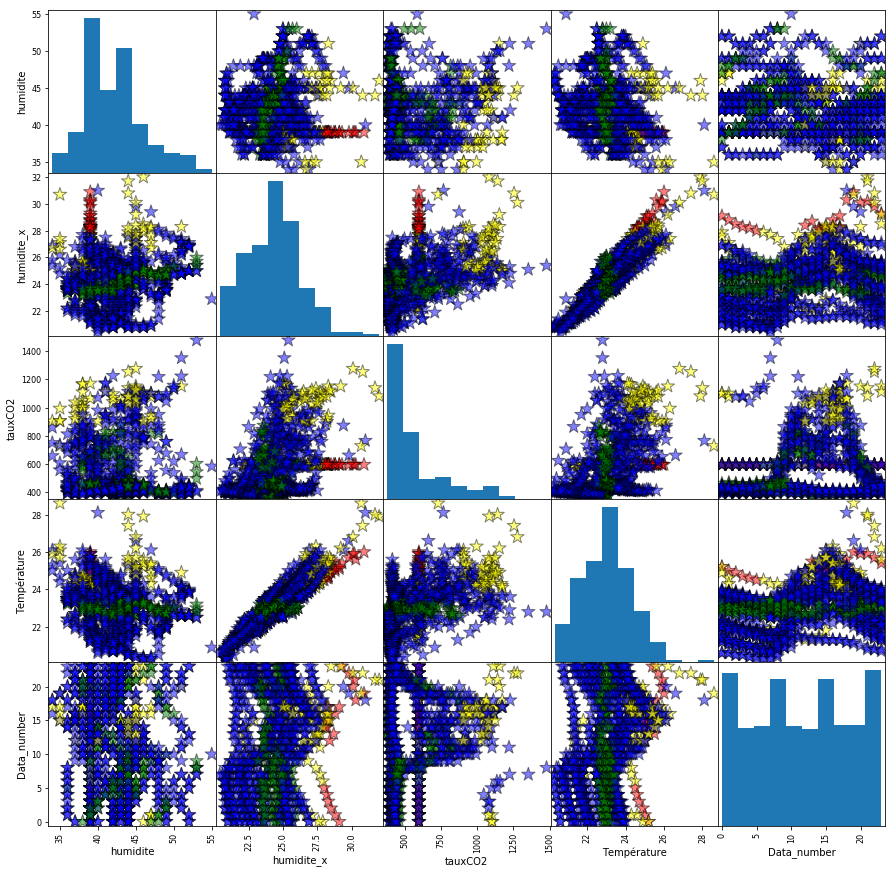

In [26]:
pd.plotting.scatter_matrix(data.loc[:1000,['humidite', 'humidite_x', 'tauxCO2', 'Température','Data_number']],
                                       c=color_list[:1000],
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 200,
                                       marker = '*',
                                       edgecolor= "black")
plt.show()

# 3) Machine Learning models

###  3.1) Creation of train and test dataset 

Here, we will split our 'train dataset' into a sub train of 77% from the first set, and a fake test set from the other 33%, to check the accuracy of our model

In [284]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.loc[:,['humidite', 'humidite_x', 'tauxCO2', 'Température','Data_number']], data['label'], test_size = 0.33)

In [285]:
X_train.shape

(224709, 5)

In [286]:
X_test.shape

(110678, 5)

### 3.2) SVM

In [331]:
#training
from sklearn.linear_model import SGDClassifier
clf_svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-2, n_iter=5, random_state=42)
clf_svm = clf_svm.fit(X_train, y_train)

/Users/jordan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [332]:
#Prediction
predicted_svm = clf_svm.predict(X_test)

In [333]:
#accuracy
np.mean(predicted_svm == y_test)

0.645503171361969

Very low accuracy, let's try to improve it.

### 2.3) Improvement

In [336]:
clf_svm.get_params()

{'alpha': 0.01,
 'average': False,
 'class_weight': None,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 5,
 'n_iter': None,
 'n_jobs': 1,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': None,
 'verbose': 0,
 'warm_start': False}

In [334]:
from sklearn.model_selection import GridSearchCV

In [339]:
parameters_svm = {'alpha': (1e-2, 1e-3), 'average': (False,True)}

gs_clf_svm = GridSearchCV(clf_svm, parameters_svm)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
gs_clf_svm.best_params_

{'alpha': 0.001, 'average': True}

In [340]:
gs_clf_svm.best_score_

0.6713349265049464

Score is still low